In [2]:
import torch 
from torchvision.datasets import MNIST
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
dataset = MNIST(root='data/',download = True)
print(len(dataset))
test_dataset = MNIST(root='data/', train = False)
len(test_dataset)

60000


C:\Python\Python3.7.6\lib\site-packages\torchvision\datasets\mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  ..\torch\csrc\utils\tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


10000

Label:  9


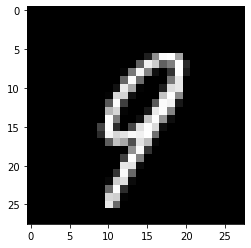

In [4]:
image,label = dataset[22]
plt.imshow(image,cmap='gray')
print('Label: ',label)

In [5]:
import torchvision.transforms as transforms

# MNIST dataset (images and labels)
dataset = MNIST(root='data/', 
                train=True,
                transform=transforms.ToTensor())

In [7]:
from torch.utils.data import random_split

train_ds, val_ds = random_split(dataset, [50000, 10000])
len(train_ds) , len(val_ds)

from torch.utils.data import DataLoader

batch_size = 128
train_loader = DataLoader(train_ds,batch_size,shuffle=True)
val_loader = DataLoader(val_ds,batch_size)

In [8]:
import torch.nn as nn

input_size = 28*28
num_classes = 10

import torch.nn.functional as F

def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item()/len(preds))

In [13]:
class RegModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.layers = nn.Sequential(
                                        nn.Flatten(),
                                        nn.Linear(input_size, 250),
                                        nn.BatchNorm1d(250),
                                        nn.ReLU(),
                                        nn.Dropout(0.3),
                                        nn.Linear(250, 50),
                                        nn.BatchNorm1d(50),
                                        nn.ReLU(),
                                        nn.Dropout(0.3),
                                        nn.Linear(50, num_classes),
                                    )

    def forward(self,xb):
        out = xb.view(xb.size(0),-1)
        return self.layers(out)

    def training_step(self, batch):
        images, labels = batch
        out = self(images)                          #   Predictions
        loss = F.cross_entropy(out, labels)
        return loss
    
    def validation_step(self, batch):
        images, labels = batch
        out = self(images)                        
        loss = F.cross_entropy(out, labels)         
        acc = accuracy(out, labels)                 #   Accuracy
        return {'val_loss':loss, 'val_acc': acc}

    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}

    def epoch_end(self, epoch, result):
        print("Epoch [{}], val_loss: {:.4f}, val_acc: {:.4f}".format(epoch, result['val_loss'], result['val_acc']))
    
model = RegModel()

def evaluate(model, val_loader):
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.Adam):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase 
        for batch in train_loader:
            loss = model.training_step(batch)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [14]:
result = evaluate(model, val_loader)
result

{'val_loss': 2.426126718521118, 'val_acc': 0.09948576241731644}

In [15]:
history = fit(5, 0.05, model, train_loader, val_loader)
# history2 = fit(10, 0.001, model, train_loader, val_loader)
# history3 = fit(5, 0.0001, model, train_loader, val_loader)

Epoch [0], val_loss: 0.2662, val_acc: 0.9227
Epoch [1], val_loss: 0.2150, val_acc: 0.9389
Epoch [2], val_loss: 0.2164, val_acc: 0.9390
Epoch [3], val_loss: 0.2069, val_acc: 0.9416
Epoch [4], val_loss: 0.2021, val_acc: 0.9442


In [16]:
test_dataset = MNIST(root='data/',train=False,transform=transforms.ToTensor())
test_loader = DataLoader(test_dataset,batch_size=256)
result = evaluate(model, test_loader)
result

{'val_loss': 0.17703935503959656, 'val_acc': 0.9541991949081421}

In [17]:
def predict_image(img, model):
    xb = img.unsqueeze(0)
    yb = model(xb)
    _, preds = torch.max(yb, dim=1)
    return preds[0].item()

In [19]:
model = model.eval()
i=0
count=0
for x in test_dataset:
    img, label = test_dataset[i]
    if label == predict_image(img,model):
        count+=1
    print('Label:', label, ', Predicted:', predict_image(img, model))
    i = i+1
    if(i==20):
        break
# print(count/len(test_dataset))

Label: 7 , Predicted: 7
Label: 2 , Predicted: 2
Label: 1 , Predicted: 1
Label: 0 , Predicted: 0
Label: 4 , Predicted: 4
Label: 1 , Predicted: 1
Label: 4 , Predicted: 4
Label: 9 , Predicted: 9
Label: 5 , Predicted: 5
Label: 9 , Predicted: 9
Label: 0 , Predicted: 0
Label: 6 , Predicted: 6
Label: 9 , Predicted: 9
Label: 0 , Predicted: 0
Label: 1 , Predicted: 1
Label: 5 , Predicted: 5
Label: 9 , Predicted: 9
Label: 7 , Predicted: 7
Label: 3 , Predicted: 3
Label: 4 , Predicted: 4
